In [1]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
#df.head()
df = df[(df.town=="BISHAN") & (df.date > date_max-12)]

from pathlib import Path
file = Path('./data/Bishan_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 2352


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127875,BISHAN,3 ROOM,115,BISHAN ST 12,64.0,Simplified,1986,62 years 08 months,470000.0,8.0,65.0
127876,BISHAN,3 ROOM,121,BISHAN ST 12,64.0,Simplified,1986,63 years 01 month,435000.0,5.0,65.0
127877,BISHAN,3 ROOM,171,BISHAN ST 13,64.0,Simplified,1988,64 years 08 months,420000.0,8.0,65.0
127878,BISHAN,3 ROOM,313,SHUNFU RD,67.0,New Generation,1985,62 years 01 month,476888.0,5.0,65.0
127879,BISHAN,3 ROOM,307,SHUNFU RD,67.0,New Generation,1985,61 years 11 months,495000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152462,BISHAN,5 ROOM,442,SIN MING AVE,125.0,Improved,1990,65 years 10 months,800000.0,8.0,76.0
152463,BISHAN,5 ROOM,442,SIN MING AVE,125.0,Improved,1990,65 years 10 months,860000.0,2.0,76.0
152464,BISHAN,EXECUTIVE,212,BISHAN ST 23,150.0,Maisonette,1992,68 years,970000.0,2.0,76.0
152465,BISHAN,EXECUTIVE,212,BISHAN ST 23,149.0,Maisonette,1992,68 years,1010000.0,5.0,76.0


In [8]:
def load_csv():
  return pd.read_csv('./data/Bishan_June22_May23.csv')
df = load_csv()
blk_street = df.block + ' ' + df.street_name

responses = []
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    print(f"{first_response['label']}, confidence {first_response['confidence']}, {i} of {len(blk_street.unique())}")
  else:
    print(f"check {add}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


115 Bishan Street 12, Singapore, confidence 1
121 Bishan Street 12, Singapore, confidence 1
171 Bishan Street 13, Singapore, confidence 1
313 Shunfu Road, Singapore, confidence 1
307 Shunfu Road, Singapore, confidence 1
308 Shunfu Road, Singapore, confidence 1
406 Sin Ming Avenue, Singapore, confidence 1
22 Sin Ming Road, Singapore, confidence 1
131 Bishan Street 12, Singapore, confidence 1
120 Bishan Street 12, Singapore, confidence 1
116 Bishan Street 12, Singapore, confidence 1
107 Bishan Street 12, Singapore, confidence 1
176 Bishan Street 13, Singapore, confidence 1
181 Bishan Street 13, Singapore, confidence 1
243 Bishan Street 22, Singapore, confidence 1
203 Bishan Street 23, Singapore, confidence 1
226 Bishan Street 23, Singapore, confidence 1
266 Bishan Street 24, Singapore, confidence 1
273B Bishan Street 24, Singapore, confidence 1
286 Bishan Street 24, Singapore, confidence 1
272 Bishan Street 24, Singapore, confidence 1
455 Sin Ming Avenue, Singapore, confidence 1
407 Sin 

1054

In [2]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,430.000000,430.000000,4.300000e+02,430.000000,430.000000,430.000000,430.000000
mean,107.625581,1989.353488,7.509216e+05,8.446512,70.106977,103.845989,1.353073
std,24.721041,6.572577,2.202638e+05,6.091048,3.559379,0.006821,0.005786
min,64.000000,1973.000000,2.950000e+05,2.000000,65.000000,103.829749,1.343878
25%,89.000000,1986.000000,6.080000e+05,5.000000,67.000000,103.842542,1.347570
50%,107.000000,1988.000000,7.365000e+05,8.000000,70.000000,103.847114,1.354749
75%,121.000000,1992.000000,8.922500e+05,11.000000,73.000000,103.851517,1.357968
max,163.000000,2011.000000,1.390000e+06,38.000000,76.000000,103.856777,1.363419


SuggestedLRs(valley=0.0010000000474974513, slide=6.309573450380412e-07)

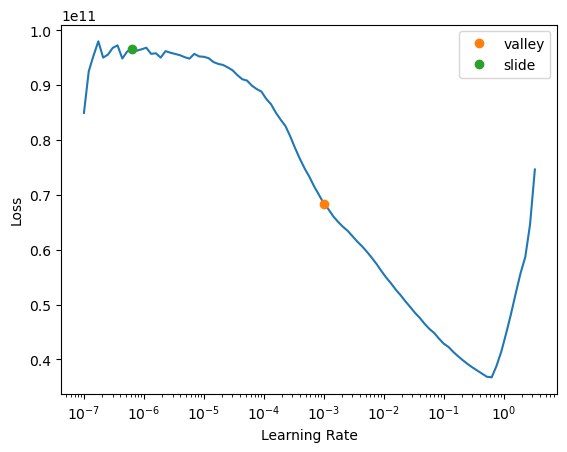

In [3]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [6]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 51827.0.


(#2) [2686050048.0,51827.0]

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 58564.69921875.


(#2) [3466628352.0,58564.69921875]

In [7]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 7*20
n2 = 6*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 120
10 of 120
20 of 120
30 of 120
40 of 120
50 of 120
60 of 120
70 of 120
80 of 120
90 of 120
100 of 120
110 of 120


In [9]:
#mrts = ["Bishan MRT"]
mrts = ["Bright Hill MRT", "Upper Thomson MRT", "Marymount MRT"]

responses = []
import http.client, urllib.parse
import json

for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


Bright Hill, Singapore, confidence 1
Upper Thomson, Singapore, confidence 1
Marymount Station, Singapore, confidence 1
pickle dumped. 2355


In [35]:
longLats["Bishan MRT"] = (103.84825, 1.35094)
pickle.dump(longLats, open('./longLat.pkl', 'wb'))


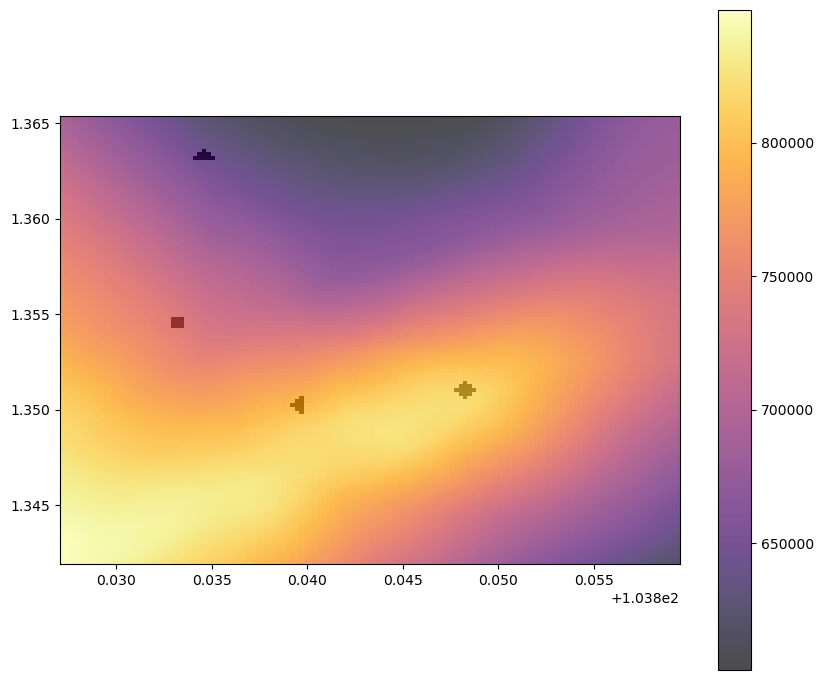

In [11]:
mrts = ["Bishan MRT","Bright Hill MRT", "Upper Thomson MRT", "Marymount MRT"]

def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))

def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1

def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1

def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
  
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1


map_up(*min_coords(*longLats[mrts[1]]))
map_sq(*min_coords(*longLats[mrts[2]]))
map_left(*min_coords(*longLats[mrts[3]]))
"""
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
(i,j) = min_coords(*longLats[mrts[4]])
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i-2]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+2]=1
mrt_map[j+1][i+1]=1
mrt_map[j+1][i]=1
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/7*6)

plt.show()

In [50]:
longLeft,longRight

(103.8288214, 103.8619606)

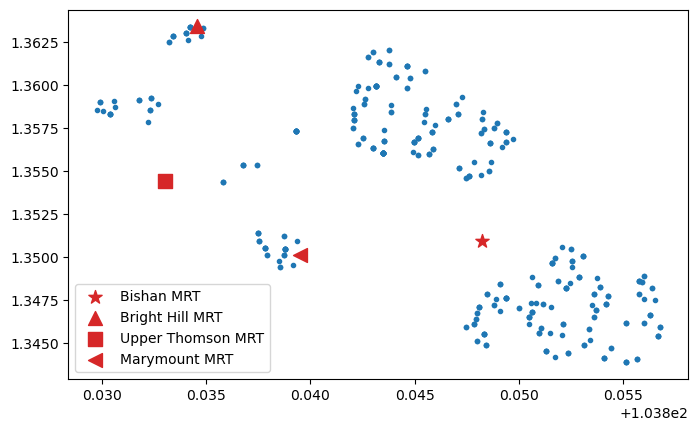

In [13]:
markers = ["*", '^', 's', '<']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower left')
fig.set_figwidth(8)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
